In [101]:
import numpy as np
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import metrics
import matplotlib as mpl

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

import csv
from sklearn.decomposition import PCA
import colorsys
import sys

lemmatizer = WordNetLemmatizer() 


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Load google pre-trained model

In [103]:
import os
from gensim.models import KeyedVectors

!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

filename = '/root/input/GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

--2021-01-07 14:16:45--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.130.29
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.130.29|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [104]:
MODELS_NUM = 318
flag = "MEAN"

##Pre-procccessing

In [105]:
corpus = [] # objet names
models_word_vectors = [[] for i in range(MODELS_NUM)] # list of lists, each conatains model object names in array
stop_words = set(stopwords.words('english'))  

with open('/content/drive/MyDrive/parsedObjectNames.txt', 'r') as fd:
    reader = csv.reader(fd)
    for row in reader:
      if row is None:
        pass
      row = row[0].split("#")
      model_id = row[0]
      object_name = row[1].lower()
      #corpus.append(object_name)
      if int(model_id) == MODELS_NUM + 1:
        break
      else:
        models_word_vectors[int(model_id)-1].append(object_name)


## Use word-embedding to get word vectors of each word in each model

In [106]:
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import wordnet

def removeNonDicWords(word_list):
  wpt = WordPunctTokenizer()
  only_recognized_words = []

  for s in word_list:
      tokens = wpt.tokenize(s)
      if tokens:  # check if empty string
          for t in tokens:
              if wordnet.synsets(t):
                  only_recognized_words.append(t)  # only keep recognized words
  return only_recognized_words

In [107]:
def splitObjectName(object_name):
    words = []
    splitted = object_name.split() # ex. ['Behavior','Tree']
    for s in splitted:
      if len(s) > 1:
        words.append(s)
    return words

def getWordListForModel(object_names_list):
  model_words = [] 
  for object_name in object_names_list:
    words_within_object_name = splitObjectName(object_name)
    for splitted_name in words_within_object_name:
      if splitted_name in model.wv.vocab and not splitted_name in stop_words:
        model_words.append(lemmatizer.lemmatize(splitted_name))
  
  model_words = removeNonDicWords(model_words)
  return list(set(model_words))

def getWordVectorsForModel(model_word_list):
  model_words_vectors = []
  for word in model_word_list:
    model_words_vectors.append(model[word])
  return model_words_vectors

def getMeanWordVectors(model_words_vectors):
    model_mean_vectors = []
    temp = []
    for embedded_vector in model_words_vectors:
      temp.append(embedded_vector)
    temp = np.array(temp)
    return temp.mean(axis=0)




In [108]:
temp = models_word_vectors[0]
temp.append('tree')
temp.append('rocks')
temp.append('x2')
temp.append("dfsfbk")
temp = getWordListForModel(temp)
temp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


['element', 'behavior', 'rock', 'named', 'specification', 'tree']

In [109]:
models_mean_vectors = [[] for i in range(MODELS_NUM)]
temp_models = []

for idx,m in enumerate(models_word_vectors,1):
  model_words = getWordListForModel(m)
  temp_models.append(model_words)
  model_words_vectors = getWordVectorsForModel(model_words)
  # if idx == 1 : print(model_words_vectors)
  model_mean_vectors = getMeanWordVectors(model_words_vectors)
  if isinstance(model_mean_vectors,np.float64):
    temp = np.zeros(300)
    models_mean_vectors[idx-1] =  temp
  # if idx == 1 : print(model_mean_vectors)
  else:
    models_mean_vectors[idx-1] =  model_mean_vectors

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [110]:

#create vector for each MODEL based OBJECTS vectors mean
norm = 0 # number of objects with valid names
no_name = 0 # number of models with no objects / no ojects with valid names
counter = 0 # number of objects with valid names
models_sum_vectors = [] # array of vectors, each one represnts a model

for m in models_word_vectors:
  model_words_list = [] # array of vectors, init after each model
  for word in m: # iterating over each object name, helps in case it is in the format of 'Behaviour Tree'
    splitted = word.split(" ") # ex. ['Behavior','Tree']
    try:
      model_words_list += [ model[w] for w in splitted ] # add a vector to the array
      norm += 1
    except:
      counter += 1
      norm += 1
  if len(model_words_list) != 0:
    result_vec = 0
    for vec in model_words_list:
      result_vec = result_vec + vec
    models_sum_vectors.append(result_vec) # add a vector representation of a model to models_vec array
  else:
    no_name += 1

x = np.array(models_sum_vectors)
y = np.array(models_mean_vectors)

#Clustering using KMEANS




In [111]:
sil = {}
k_means_data = {}
kmax = 10

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(y)
  labels = kmeans.labels_ 
  centroids = kmeans.cluster_centers_
  k_means_data[k] = { 'kmeans' : kmeans, 'labels':labels, 'centroids': centroids }
  silhouette_score = metrics.silhouette_score(y, labels, metric='euclidean')
  sil[k] = silhouette_score

best_k = max(sil, key=sil.get)
labels = k_means_data[best_k]['labels']
centroids = k_means_data[best_k]['centroids']
k_means = k_means_data[best_k]['kmeans']

print("Optimal number of clusters:" , best_k)

# for idx,label in enumerate(kmeans.labels_):
#   print("Model {} is in : {}".format(idx,label))


Optimal number of clusters: 2


#Visualize K-Means


No handles with labels found to put in legend.


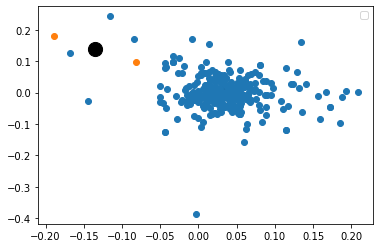

In [112]:
for i in set(k_means.labels_):
    index = k_means.labels_ == i
    plt.plot(y[index,0], y[index,1], 'o')
plt.scatter(centroids[:,0] , centroids[:,1] , s = 200, color = 'k')
plt.legend()
plt.show()

#Clustering using DBSCAN

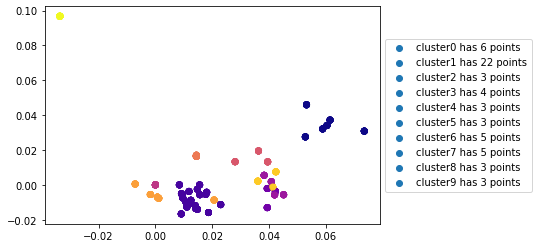

In [150]:

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

dbscan = DBSCAN(min_samples = 3,eps = 0.2)
dbscan_clusters = dbscan.fit_predict(y)

ctr = 0
for label in dbscan_clusters:
  if label == -1:
    ctr+=1
  
#Remove Noise clusters
y_filt = []
rel_model_ids = []

for model_id,label in enumerate(dbscan_clusters):
  if label >= 0:
    y_filt.append([y[model_id,0],y[model_id,1]])
    rel_model_ids.append(model_id)

new_clusters = np.delete(dbscan_clusters, np.where(dbscan_clusters == -1))
y_filt = np.array(y_filt)

clusters_found = len(set(new_clusters))

legends = []
for i in range(clusters_found):
    legends.append('cluster{}'.format(i))


for i in range(clusters_found):
   plt.scatter(y_filt[:, 0], y_filt[:, 1], c=new_clusters, cmap="plasma" ,
               label= legends[i] + " has {} points".format(y_filt[:,0][new_clusters==i].shape[0]))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# analyze results
results = [[] for i in range(clusters_found)]

for idx,i in enumerate(results):
  results[idx] = []
for idx in rel_model_ids:
    model_cluster = dbscan_clusters[idx]
    results[model_cluster].append((idx,temp_models[idx-1][:]))


# print clustering results
# for idx,models in enumerate(results):
#   print ( '*' * 50)
#   print("CLUSTER NUMBER : {}".format(idx))
#   print ( '*' * 50)

#   for model_id,model_words in models:
#     print("Model ID : {} \n".format(model_id))
#     print("{} \n".format(model_words))


